# Germinal center replay modeling

In [2]:
# NBVAL_IGNORE_OUTPUT

import numpy as np
import matplotlib.pyplot as plt

from gcdyn import bdms, gpmap, mutators, poisson, utils
from experiments import replay

Genotype-phenotype map based on additive DMS binding effects

In [3]:
gp_map = gpmap.AdditiveGPMap(replay.bind_df, nonsense_phenotype=replay.bind_df.min().min())
assert gp_map(replay.NAIVE_SEQUENCE) == 0

Response functions

In [4]:
birth_rate = poisson.SoftReluResponse(xscale=2.0, xshift=-2.5, yscale=0.2, yshift=0.0)
death_rate = poisson.ConstantResponse(0.1)
mutation_rate = poisson.SequenceContextMutationResponse(replay.mutability, replay.seq_to_contexts, mutation_intensity=1.0)

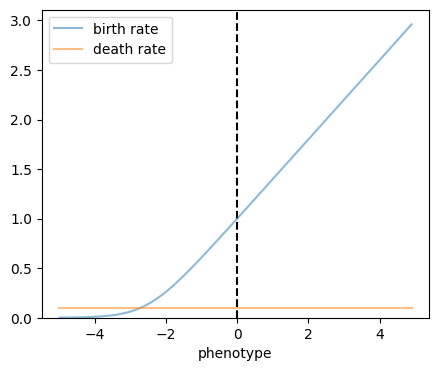

In [5]:
# NBVAL_IGNORE_OUTPUT

x_grid = np.arange(-5, 5, 0.1)

plt.figure(figsize=(5, 4))
plt.axvline(0, color="k", linestyle="--")
plt.plot(x_grid, birth_rate.λ_phenotype(x_grid), label="birth rate", alpha=0.5)
plt.plot(x_grid, death_rate.λ_phenotype(x_grid), label="death rate", alpha=0.5)
# plt.fill_between(x_grid, mutator.prob(0, x_grid), color="grey", label="distribution of phenotypic\neffects of mutations", alpha=0.5)
plt.xlabel('phenotype')
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

Mutator

In [6]:
mutator = mutators.SequencePhenotypeMutator(mutators.ContextMutator(mutability=replay.mutability,
                                                                    substitution=replay.substitution,
                                                                    seq_to_contexts=replay.seq_to_contexts),
                                            gp_map)

In [7]:
rng = np.random.default_rng(seed=0)

In [8]:
time_to_sampling = 5
for iter in range(1000):
    try:
        tree = bdms.TreeNode()
        tree.sequence = replay.NAIVE_SEQUENCE
        tree.x = gp_map(tree.sequence)
        tree.evolve(
            time_to_sampling,
            birth_rate=birth_rate,
            death_rate=death_rate,
            mutation_rate=mutation_rate,
            mutator=mutator,
            min_survivors=100,
            max_leaves=1000,
            birth_mutations=False,
            seed=rng,
        )
        print(f"try {iter + 1} succeeded, tip count: {len(tree)}")
        break
    except bdms.TreeError as e:
        print(f"try {iter + 1} failed, {e}", flush=True)
        continue

try 1 failed, 'minimum number of survivors 100 not attained'
try 2 failed, 'minimum number of survivors 100 not attained'
try 3 failed, 'minimum number of survivors 100 not attained'
try 4 failed, 'minimum number of survivors 100 not attained'
try 5 succeeded, tip count: 403


In [9]:
tree.sample_survivors(n=20, seed=rng)
tree.prune()

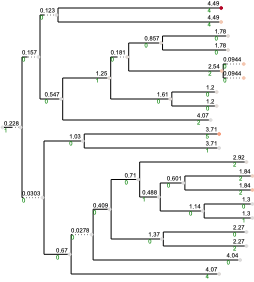

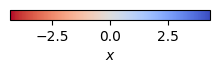

In [10]:
# NBVAL_SKIP

tree.render("%%inline")

In [11]:
tree.total_mutations = 0

for node in tree.iter_descendants(strategy="preorder"):
    node.total_mutations = node.n_mutations + node.up.total_mutations

[leaf.total_mutations for leaf in tree.iter_leaves()]

[5, 5, 2, 2, 4, 4, 2, 2, 3, 6, 2, 3, 4, 4, 2, 3, 1, 3, 1, 5]

In [12]:
# Optionally write out tree and sequences.

if False:
    with open("tree.nwk", "w") as fp:
        fp.write(tree.write()+"\n")

    utils.write_leaf_sequences_to_fasta(tree, "seqs.fasta", naive=replay.NAIVE_SEQUENCE)